# 0. Setup

## 0.1 Import Libraries

In [1]:
#dir.create("~/R/libs", recursive = TRUE)

# Install the packages to this directory
#install.packages("jsonlite", lib = "~/R/libs")
#install.packages("httr", lib = "~/R/libs")
#install.packages("xml2", lib = "~/R/libs")

# Load the packages from the custom library
library(jsonlite, lib.loc = "~/R/libs")
library(httr, lib.loc = "~/R/libs")
library(curl, lib.loc = "~/R/libs")
library(xml2, lib.loc = "~/R/libs")

Using libcurl 7.81.0 with OpenSSL/3.0.2


Attaching package: ‘curl’


The following object is masked from ‘package:httr’:

    handle_reset




## 0.2 Define Variables

In [3]:
read_credentials <- function(file_path) {
  credentials <- fromJSON(file_path)
  return(credentials)
}

# Read credentials
credentials <- read_credentials('credentials.json')
AUTHENTICATION_URL <- credentials$AUTHENTICATION_URL
AUTHENTICATION_DETAILS <- credentials$AUTHENTICATION_DETAILS

FROST_DATASTREAMS <- c("TVOC@THI.FE.003", "TVOC@THI.FE.004")
FROST_TIME_START = "2024-06-24T00:00:00+01:00"
FROST_TIME_END = "2024-07-03T12:00:00+01:00"
FROST_DATASTREAM_QUERY <- sprintf("Datastreams?$filter=substringof('%s',name)", FROST_DATASTREAMS)
FROST_URL <- "https://kdp-ediaqi.know-center.at/FROST-Server/v1.1/"

## 0.3 Define Authentication Function

In [4]:
get_access_token <- function(auth_url, auth_details) {
  # Perform POST request to obtain access token
  auth_response <- POST(url = auth_url,
                        body = auth_details,
                        encode = "form",
                        verbose())  # Optional: verbose output for debugging
  
  # Check for HTTP errors
  stop_for_status(auth_response)
  
  # Extract access token from JSON response
  token_response <- content(auth_response)
  access_token <- token_response$access_token
  
  return(access_token)
}
access_token <- get_access_token(AUTHENTICATION_URL, AUTHENTICATION_DETAILS)

## 0.4 Define Download Function

In [5]:
get_frost_data <- function(base_url, filter_query, access_token) {
  headers <- add_headers(Authorization = paste("Bearer", access_token))
  
  # Initialize an empty list for storing results
  res <- list()
  url_to_request <- base_url
  continue_fetching <- TRUE
  first_request <- TRUE
  repeat {
    if (first_request) {
    response <- GET(url_to_request, query=filter_query, add_headers(Authorization = paste("Bearer", access_token)))
    first_request <- FALSE
    } else {
        response <- GET(url_to_request, add_headers(Authorization = paste("Bearer", access_token)))
    }
    # Check for HTTP errors
    stop_for_status(response)
    
    # Extract JSON content
    json_content <- content(response, "parsed")
    
    # Append current page's data to results
    res <- c(res, json_content$value)
    
    # Check for next page link
    if ("@iot.nextLink" %in% names(json_content)) {
      url_to_request <- json_content$`@iot.nextLink`
      filter_query <- list()  # Clear filter_query since next URL already includes parameters
    } else {
      continue_fetching <- FALSE
    }
    
    # Break the loop if there are no more pages
    if (!continue_fetching) {
      break
    }
  }
  return(res)
}

# 1. Dowload the Data

In [7]:
query <- "Observations?$expand=Datastream($select=id,name)&$filter="
query <- ""
# Construct the filter part for Datastreams
for (idx in seq_along(FROST_DATASTREAMS)) {
  if (idx == 1) {
    query <- paste0(query, "(Datastream/name eq '", FROST_DATASTREAMS[idx], "'")
  } else {
    query <- paste0(query, " or Datastream/name eq '", FROST_DATASTREAMS[idx], "'")
  }
  if (idx == length(FROST_DATASTREAMS)) {
    query <- paste0(query, ")")
  }
}

# Add the time range to the query
query <- paste0(query, " and phenomenonTime ge ", enc2utf8(FROST_TIME_START), 
                " and phenomenonTime le ", enc2utf8(FROST_TIME_END))
filter_query = list("$expand" = "Datastream($select=id,name)", "$filter"= query)
# Print the final query
print(query)
observations <- get_frost_data(paste0(FROST_URL,"Observations"), filter_query, access_token)

[1] "(Datastream/name eq 'TVOC@THI.FE.003' or Datastream/name eq 'TVOC@THI.FE.004') and phenomenonTime ge 2024-06-24T00:00:00+01:00 and phenomenonTime le 2024-07-03T12:00:00+01:00"


# 2. Transform Data into R DataFrame

In [8]:
df <- data.frame(
  id = sapply(observations, `[[`, "@iot.id"),
  Datastream = sapply(observations, function(x) x$Datastream$name),
  result = sapply(observations, `[[`, "result"),
  phenomenonTime = sapply(observations, `[[`, "phenomenonTime"),
  stringsAsFactors = FALSE
)

# Split the phenomenonTime column to get start_time
df$start_time <- sapply(strsplit(df$phenomenonTime, "/"), `[`, 1)

# Convert start_time to date-time format
df$start_time <- as.POSIXct(df$start_time, format = "%Y-%m-%dT%H:%M:%OSZ")

# Rename the columns
colnames(df) <- c("id", "Datastream", "result", "phenomenonTime", "start_time")

# 3. Plotting

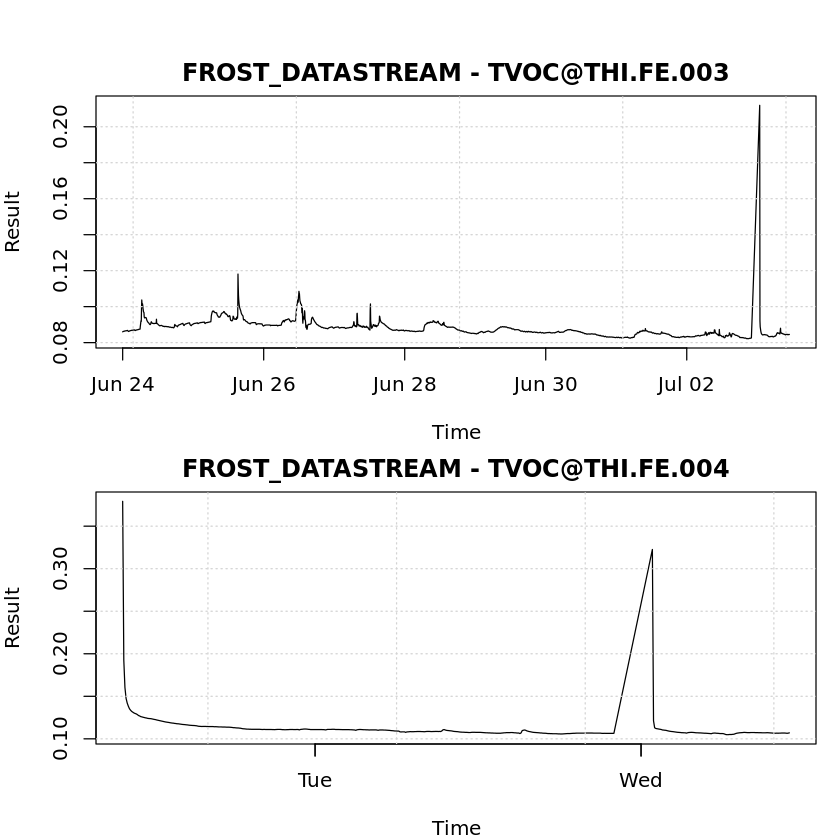

In [9]:
unique_datastreams <- unique(df$Datastream)

# Calculate the number of datastreams
num_datastreams <- length(unique_datastreams)

# Set up the layout for multiple plots
par(mfrow = c(num_datastreams, 1), mar = c(4, 4, 2, 1), oma = c(0, 0, 2, 0))

# Loop over each unique datastream and create a plot in its respective subplot
for (datastream in unique_datastreams) {
  # Filter the dataframe for the current datastream
  df_filtered <- df[df$Datastream == datastream, ]
  
  # Plot the data
  plot(df_filtered$start_time, df_filtered$result, type = "l", xlab = "Time", ylab = "Result", main = paste("FROST_DATASTREAM -", datastream))
  
  # Customize the plot
  grid()
}

# Reset the layout
par(mfrow = c(1, 1))